In [51]:
import pandas as pd
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
data = pd.read_csv('../data/train/gym_members_exercise_tracking_train.csv')

In [53]:
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,20,Male,55.0,1.60,172,168,67,1.12,1035.0,Yoga,24.0,3.2,4,2,21.48
1,39,Female,60.6,1.65,162,167,63,0.92,768.0,HIIT,27.6,1.7,3,1,22.26
2,54,Female,75.6,1.72,194,154,60,0.97,672.0,Cardio,26.4,1.9,3,1,25.55
3,24,Female,58.9,1.51,187,157,68,1.04,816.0,Cardio,31.7,2.5,2,1,25.83
4,20,Female,65.4,1.52,185,127,50,1.03,654.0,Yoga,28.0,2.2,4,2,28.31


In [54]:
# Add the parent directory to the path
sys.path.append(os.path.abspath('..'))

from src.preprocessing import preprocess_data

df = preprocess_data(data, 'experience_level')

df.head()
df['experience_level'].unique()

No missing values found, returning original dataframe
Categorical columns: ['Gender', 'Workout_Type']
The max imbalance occurs on class 2 at 11.07% greater than the next greatest class


array([2, 1, 3])

In [55]:
from src.model import train_model
from src.preprocessing import test_val_train_split

X_train, y_train, X_test, y_test, X_val, y_val = test_val_train_split(df, 'experience_level')

model = train_model(X_train, y_train, X_val, y_val)

Target values transformed from 1-3 to 0-2
Value mapping: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2)}
Epoch 1/100


/Users/apple/Documents/dev/ALU/2025-01/MLOP_Summative/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3260 - loss: 1.8055 - val_accuracy: 0.6693 - val_loss: 1.5003
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7101 - loss: 1.3959 - val_accuracy: 0.7087 - val_loss: 1.2463
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 1.1553 - val_accuracy: 0.7874 - val_loss: 1.0711
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8882 - loss: 0.9554 - val_accuracy: 0.8189 - val_loss: 0.9452
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.8477 - val_accuracy: 0.8346 - val_loss: 0.8514
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9080 - loss: 0.7552 - val_accuracy: 0.8346 - val_loss: 0.7889
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.6877 - val_accuracy: 0.8268 - val_loss: 0.7351
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9049 - loss: 0.6526 - val_accuracy: 0.8425 - val_loss: 0.6

In [57]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


def evaluate_model(model_name, model, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> dict:
    # Get model predictions
    raw_predictions = model.predict(X_test)
    print(f"Raw predictions shape: {raw_predictions.shape}")
    
    # Handle different prediction formats
    if isinstance(model, tf.keras.models.Model):
        # For neural networks
        if len(raw_predictions.shape) > 1 and raw_predictions.shape[1] > 1:
            # Multi-class case (more than 2 classes)
            y_pred = np.argmax(raw_predictions, axis=1)
        else:
            # Binary case
            y_pred = (raw_predictions.flatten() >= threshold).astype(int)
    else:
        # For sklearn models
        if hasattr(model, 'predict_proba') and len(np.unique(y_test)) > 2:
            # Multi-class with probabilities
            y_pred = np.argmax(model.predict_proba(X_test), axis=1)
        else:
            # Direct predictions
            y_pred = model.predict(X_test)
    
    # Ensure predictions match y_test length
    if len(y_pred) != len(y_test):
        raise ValueError(f"Prediction length ({len(y_pred)}) doesn't match y_test length ({len(y_test)})")
    
    # Convert y_test to numpy array
    y_test_np = np.array(y_test)
    
    # Get unique classes
    classes = np.unique(np.concatenate([y_test_np, y_pred]))
    n_classes = len(classes)
    
    # Set appropriate average for metrics based on number of classes
    if n_classes == 2:
        average = 'binary'
    else:
        average = 'weighted'  # Good default for imbalanced classes
    
    print(f"Number of classes detected: {n_classes}, using average='{average}'")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_np, y_pred)
    f1 = f1_score(y_test_np, y_pred, average=average)
    precision = precision_score(y_test_np, y_pred, average=average)
    recall = recall_score(y_test_np, y_pred, average=average)
    
    # Create class labels for confusion matrix
    if n_classes == 2:
        class_labels = ['Not Sold Out', 'Sold Out']
    else:
        class_labels = [f'Class {i}' for i in range(n_classes)]
    
    confusion = confusion_matrix(y_test_np, y_pred)
    classification_rep = classification_report(y_test_np, y_pred)

    results = f'''\
    {model_name} Accuracy: {accuracy:.2f}
    {model_name} F1 Score: {f1:.2f}
    {model_name} Precision: {precision:.2f}
    {model_name} Recall: {recall:.2f}
    {model_name} Classification Report: 
{classification_rep}
    '''

    # Plotting confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, cmap='coolwarm', fmt='d', 
                xticklabels=class_labels[:len(confusion)], 
                yticklabels=class_labels[:len(confusion)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    print(f'------------------------------------- {model_name} Stats -------------------------------------')
    if isinstance(model, tf.keras.models.Model):
        loss = model.evaluate(X_test, y_test)[0]
        print(f'''    {model_name} Loss: {loss:.2f}''')
    print(results)
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Raw predictions shape: (149, 3)
Number of classes detected: 3, using average='weighted'


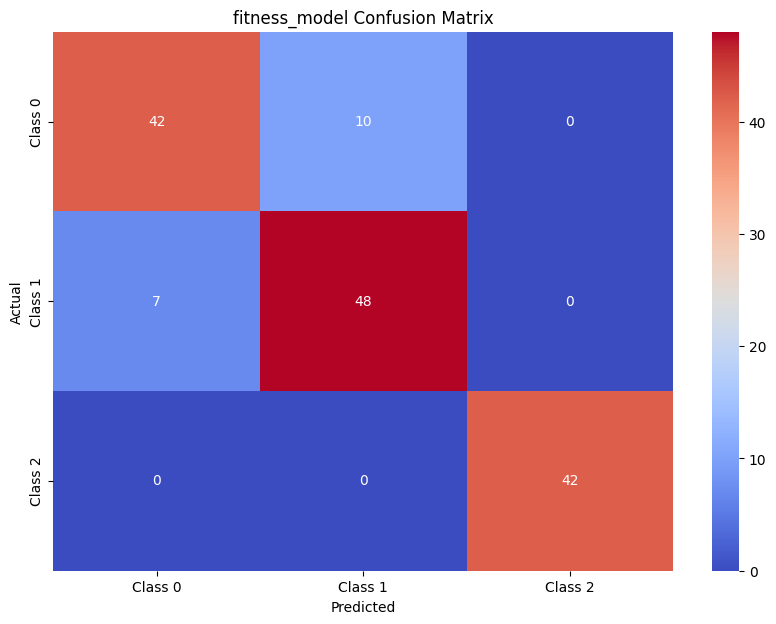

------------------------------------- fitness_model Stats -------------------------------------
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8869 - loss: 0.3082 
    fitness_model Loss: 0.31
    fitness_model Accuracy: 0.89
    fitness_model F1 Score: 0.89
    fitness_model Precision: 0.89
    fitness_model Recall: 0.89
    fitness_model Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        52
           1       0.83      0.87      0.85        55
           2       1.00      1.00      1.00        42

    accuracy                           0.89       149
   macro avg       0.89      0.89      0.89       149
weighted avg       0.89      0.89      0.89       149

    


{'accuracy': 0.8859060402684564,
 'f1': 0.8857260971093248,
 'precision': 0.8865011406089859,
 'recall': 0.8859060402684564}

In [58]:
evaluate_model(
    model=model,
    model_name="fitness_model",
    X_test=X_test,
    y_test=y_test
    )